In [50]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [9]:
#standard imports
import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats

#let's import the SVM classifier
from sklearn.svm import LinearSVC

#our own internal utility unctions
import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
from utils import featurewise_norm


In [5]:
#ok let's load the data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]

#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

In [3]:
HUMAN_DATA_PATH = "/mnt/data3/yamins/visual/human_behavior.hdf5"
Behavioral_Dataset = h5py.File(HUMAN_DATA_PATH)

In [17]:
expnames = [('Basic_categorization', 'category')] + \
            [(c + '_identification', 'obj') for c in unique_categories]

    
human_confmats = {}
for expname, exp_goal in expnames:
    if 'Basic' in expname:
        ucats = unique_categories
    else:
        catn = expname.split('_')[0]
        ucats = objects_by_category[catn]
    preds = Behavioral_Dataset[expname]['chosen']
    actuals = Behavioral_Dataset[expname]['actual']
    vls = Behavioral_Dataset[expname]['variation_level']
    cms = np.array([metrics.get_confusion_matrix(p, a, ucats) for p, a in zip(preds, actuals)])
    human_confmats[expname] = {'all': cms}
    for v in ['V0', 'V3', 'V6']:
        cms = np.array([metrics.get_confusion_matrix(p[vl==v], a[vl==v], ucats) 
                             for p, a, vl in zip(preds, actuals, vls)])
        human_confmats[expname][v] = cms
                     

In [91]:
pretty_good_cval = 1e-3
var_levels = ['all', 'V0', 'V3', 'V6']
        
def get_splits_and_labels(expname, exp_goal, vl):
    num_test = 10
    if vl == 'V0':
        num_test = 5
        num_train = 10 - num_test
    elif vl in ['V3', 'V6']:
        num_train = 40 - num_test
    else:
        num_train = 90 - num_test
    if exp_goal == 'category':
        if vl == 'all':
            train_filter = None
            test_filter = None
        else:
            train_filter = lambda x: (x['variation_level'] == vl)
            test_filter = lambda x: (x['variation_level'] == vl)

        labels = meta_array['category']
    else:
        catn = expname.split('_')[0]
        if vl == 'all':
            train_filter = lambda x: (x['category'] == catn)
            test_filter = lambda x: (x['category'] == catn)
        else:
            train_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)
            test_filter = lambda x: (x['variation_level'] == vl) and (x['category'] == catn)

        labels = meta_array['object_name']
        
    splits = cv.get_splits(metadata=meta_array, 
                           split_by_func=lambda x: x['object_name'],  #we're balancing splits by object
                           num_splits=5,  
                           num_per_class_test=num_test,  
                           num_per_class_train=num_train,
                           train_filter=train_filter,
                           test_filter=test_filter
                           )
   
    return splits, labels
    


In [92]:
neural_results = {}
for expname, exp_goal in expnames:
    neural_results[expname] = {}
    for vl in var_levels:
        print('Getting results for %s %s' % (expname, vl))
        splits, labels = get_splits_and_labels(expname, exp_goal, vl)
        neural_results[expname][vl] = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                     labels=labels,
                                     splits=splits,
                                     model_class=LinearSVC,
                                     model_args={'C': pretty_good_cval})
        acc = neural_results[expname][vl][0]['test']['mean_accuracy'] * 100
        print('Mean accuracy: %.2f' % acc)


Getting results for Basic_categorization all
Mean accuracy: 74.38
Getting results for Basic_categorization V0
Mean accuracy: 92.38
Getting results for Basic_categorization V3
Mean accuracy: 85.03
Getting results for Basic_categorization V6
Mean accuracy: 61.44
Getting results for Animals_identification all
Mean accuracy: 69.50
Getting results for Animals_identification V0
Mean accuracy: 89.00
Getting results for Animals_identification V3
Mean accuracy: 75.50
Getting results for Animals_identification V6
Mean accuracy: 52.25
Getting results for Boats_identification all
Mean accuracy: 57.50
Getting results for Boats_identification V0
Mean accuracy: 96.00
Getting results for Boats_identification V3
Mean accuracy: 55.50
Getting results for Boats_identification V6
Mean accuracy: 36.50
Getting results for Cars_identification all
Mean accuracy: 32.00
Getting results for Cars_identification V0
Mean accuracy: 72.50
Getting results for Cars_identification V3
Mean accuracy: 37.00
Getting results 

In [93]:
neural_confmats = {}
for expname, exp_goal in expnames:
    neural_confmats[expname] = {}
    for vl in var_levels:
        neural_confmats[expname][vl] = \
             neural_results[expname][vl][0]['test']['confusion_matrices']


In [56]:
def get_off_diagonal(mat):
    n = mat.shape[0]
    i0, i1 = np.triu_indices(n, 1)
    i2, i3 = np.tril_indices(n, -1)
    return np.concatenate([mat[i0, i1], mat[i2, i3]])

In [ ]:
plt.matshow(neural_confmats['Basic_categorization']['all'].mean(0))
plt.matshow(human_confmats['Basic_categorization']['all'].mean(0))

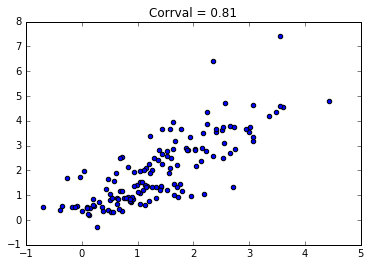

In [94]:
_ks = expnames
_vls = ['V3','V6']
clip = 100

d1 = []
d2 = []
for _k, _ig in _ks:
    for _vl in _vls:
        neural_dprime = np.clip(neural_results[_k][_vl][0]['test']['mean_dprime'], -clip, clip)
        human_dprime = np.clip(metrics.dprime_confmat(human_confmats[_k][_vl].mean(0)), -clip, clip)
        d1.extend(neural_dprime)   
        d2.extend(human_dprime)

plt.scatter(d1, d2)
corrval = stats.spearmanr(d1, d2)[0]
plt.title('Corrval = %.2f' % corrval)

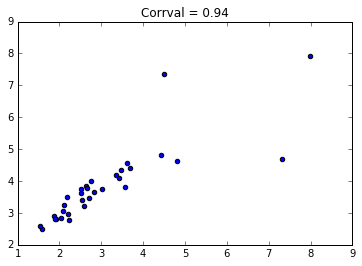

In [95]:
_ks = [('Basic_categorization', None)]
_vls = var_levels
clip = 100

d1 = []
d2 = []
for _k, _ig in _ks:
    for _vl in _vls:
        neural_dprime = np.clip(neural_results[_k][_vl][0]['test']['mean_dprime'], -clip, clip)
        human_dprime = np.clip(metrics.dprime_confmat(human_confmats[_k][_vl].mean(0)), -clip, clip)
        d1.extend(neural_dprime)   
        d2.extend(human_dprime)

plt.scatter(d1, d2)
corrval = stats.spearmanr(d1, d2)[0]
plt.title('Corrval = %.2f' % corrval)

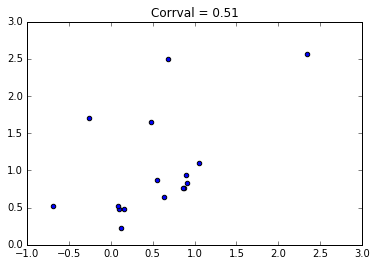

In [96]:
_ks = [ ('Cars_identification', None)]
_vls = ['V3', 'V6']
clip = 100

d1 = []
d2 = []
for _k, _ig in _ks:
    for _vl in _vls:
        neural_dprime = np.clip(neural_results[_k][_vl][0]['test']['mean_dprime'], -clip, clip)
        human_dprime = np.clip(metrics.dprime_confmat(human_confmats[_k][_vl].mean(0)), -clip, clip)
        d1.extend(neural_dprime)   
        d2.extend(human_dprime)

plt.scatter(d1, d2)
corrval = stats.spearmanr(d1, d2)[0]
plt.title('Corrval = %.2f' % corrval)